<a href="https://colab.research.google.com/github/imenebak/Sentiment-Analysis/blob/main/Kaggel_IMDbMovies.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

1. Go to your account, Scroll to API section and Click Expire API Token to remove previous tokens

2. Click on Create New API Token - It will download kaggle.json file on your machine.

In [ ]:
#importing data process bibliotheques keras stuff
import pandas as pd
import numpy as np
import re
import nltk
import matplotlib.pyplot as plt
from nltk.corpus import stopwords

from numpy import array
from keras.preprocessing.text import one_hot
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers.core import Activation, Dropout, Dense
from keras.layers import Flatten
from keras.layers import Conv1D
from keras.layers import LSTM
from keras.layers import GlobalMaxPooling1D
from keras.layers.embeddings import Embedding
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras import backend

In [ ]:
from google.colab import files
files.upload()  #this will prompt you to upload the kaggle.json

In [ ]:
!pip install -q kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!ls ~/.kaggle
!chmod 600 /root/.kaggle/kaggle.json  # set permission

kaggle.json


In [ ]:
! kaggle datasets download -d lakshmi25npathi/imdb-dataset-of-50k-movie-reviews

 97% 25.0M/25.7M [00:00<00:00, 92.8MB/s]
100% 25.7M/25.7M [00:00<00:00, 126MB/s] 


In [ ]:
!unzip imdb-dataset-of-50k-movie-reviews

Archive:  imdb-dataset-of-50k-movie-reviews.zip
  inflating: IMDB Dataset.csv        


In [ ]:
def drawplot(history):
  plt.plot(history.history['acc'])
  plt.plot(history.history['val_acc'])

  plt.title('model accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train','test'], loc = 'upper left')
  plt.show()

  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])

  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train','test'], loc = 'upper left')
  plt.show()

In [ ]:
def prediction(ins):
  for instance in ins:
    print(instance)
    instance = tokenizer.texts_to_sequences(instance)

    flat_list = []
    for sublist in instance:
        for item in sublist:
            flat_list.append(item)

    flat_list = [flat_list]

    instance = pad_sequences(flat_list, padding='post', maxlen=maxlen)

    a = model.predict(instance)
    if a[0] < 0.5 :
      print("Negative rev")
    else:
      print("Positive rev")


# **Data Analysing**

In [ ]:
movie_reviews = pd.read_csv("/content/IMDB Dataset.csv")
movie_reviews.isnull().values.any()
movie_reviews.shape

(50000, 2)

In [ ]:
movie_reviews.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [ ]:
#Summary of the dataset
movie_reviews.describe()

,review,sentiment
count,50000,50000
unique,49582,2
top,Loved today's show!!! It was a variety and not...,negative
freq,5,25000


In [ ]:
movie_reviews["review"][3]

"Basically there's a family where a little boy (Jake) thinks there's a zombie in his closet & his parents are fighting all the time.<br /><br />This movie is slower than a soap opera... and suddenly, Jake decides to become Rambo and kill the zombie.<br /><br />OK, first of all when you're going to make a film you must Decide if its a thriller or a drama! As a drama the movie is watchable. Parents are divorcing & arguing like in real life. And then we have Jake with his closet which totally ruins all the film! I expected to see a BOOGEYMAN similar movie, and instead i watched a drama with some meaningless thriller spots.<br /><br />3 out of 10 just for the well playing parents & descent dialogs. As for the shots with Jake: just ignore them."

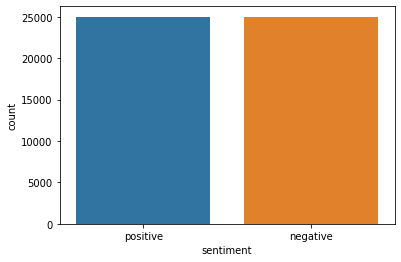

In [ ]:
import seaborn as sns
sns.countplot(x='sentiment', data=movie_reviews)

In [ ]:
movie_reviews.isna().sum() # Checking for any missing values

review       0
sentiment    0
dtype: int64

# **Data Processing**




---



*   As the sentences have html line breaks in them, they would be replaced with "." prior to next steps of preprocessing, else the tags would lose meaning and dilute the sentences.

*   Inspecting the dataset reveled that there are ( ½, ¾, ,ª,³,º) characters which are not numbers and hence have been cleaned explictly.


*   TweetTokenizer - seems to be smartly seperating numbers into different token i.e. "entries.3/10" is sepeared into two tokens "entries" and "310" so that we can remove 310 in next iterations, also TweetTokenizer is idenityfing words like "cannot" and "gonna" as one token. TreebankWordTokenizer and word tokenizer are identifying "entries310" as one token and "cannot" as two tokens i.e. "can" and "not" and hence TweetTokenizer is chosen.
*   As the corupus mostly contain english words, I have chosen to remove english stop words exlcuding "n't","nt", "not", "no" as they might contribute to sentiment.
numbers have also been removed
There are a lot of words which are seperated by punctuation marks and not by space for example - crazy-Chinese-musical-in-Paris-with-Barbet-Schroeder but.oh.dear.god.it.sounds.like.they're.all.reading.from.scripts. Hence for words with size greater than 20 punctuation marks and underscore have been replaced by space and for the rest punctuation marks have been removed.


*   Hyperlinks have also been removed using regex patterns
Using Lemmatisation over stemming as words like "flies" will be handled better using Lemmatisation
Underscores are handled differently than punctuation marks as there are some curse words censored by underscre example - f__ed, if we remove underscore completely then the meaning of the word changes entirely, hence tokens that **have at the beginning / end** have been handled using st.stip("_") and underscore in between tokens with size less than 20 have been left at they are.

*  A lot of user exclaimed words were also found in different forms (example - yeeshhhhhhhhhhhhhhhhh) and hence the most frequent ones have been identified and replaced by the respective words using regex patterns.
* There are also multiple words which are not seperated by space or punctuation mark,(Example - heyijustleftmycoatbehind) these are hardcoded into a dict and then replaced

In [ ]:
def preprocess_text(sen):
    # Removing html tags
    sentence = remove_tags(sen)
    # Remove punctuations and numbers
    sentence = re.sub('[^a-zA-Z]', ' ', sentence)
    # Single character removal
    sentence = re.sub(r"\s+[a-zA-Z]\s+", ' ', sentence)
    # Removing multiple spaces
    sentence = re.sub(r'\s+', ' ', sentence)
    return sentence

In [ ]:
TAG_RE = re.compile(r'<[^>]+>')
def remove_tags(text):
    return TAG_RE.sub('', text)

In [ ]:
X = []
sentences = list(movie_reviews['review'])
for sen in sentences:
    X.append(preprocess_text(sen))

In [ ]:
X[3]

'Basically there a family where little boy Jake thinks there a zombie in his closet his parents are fighting all the time This movie is slower than soap opera and suddenly Jake decides to become Rambo and kill the zombie OK first of all when you re going to make film you must Decide if its thriller or drama As drama the movie is watchable Parents are divorcing arguing like in real life And then we have Jake with his closet which totally ruins all the film expected to see BOOGEYMAN similar movie and instead watched drama with some meaningless thriller spots out of just for the well playing parents descent dialogs As for the shots with Jake just ignore them '

In [ ]:
y = movie_reviews['sentiment']
y = np.array(list(map(lambda x: 1 if x=="positive" else 0, y)))

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

* create a word-to-index dictionary

In [ ]:
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(X_train)
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

In [ ]:
vocab_size = len(tokenizer.word_index) + 1# Adding 1 because of reserved 0 index
maxlen = 100
X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

In [ ]:
!wget "http://nlp.stanford.edu/data/glove.6B.zip"

--2020-12-04 18:02:19--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2020-12-04 18:02:19--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2020-12-04 18:02:19--  http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glove.6

In [ ]:
!unzip /content/glove.6B.zip

Archive:  /content/glove.6B.zip
  inflating: glove.6B.50d.txt        
  inflating: glove.6B.100d.txt       
  inflating: glove.6B.200d.txt       
  inflating: glove.6B.300d.txt       


In [ ]:
from numpy import array
from numpy import asarray
from numpy import zeros

embeddings_dictionary = dict()
glove_file = open('/content/glove.6B.100d.txt', encoding="utf8")

for line in glove_file:
    records = line.split()
    word = records[0]
    vector_dimensions = asarray(records[1:], dtype='float32')
    embeddings_dictionary [word] = vector_dimensions
glove_file.close()

In [ ]:
embedding_matrix = zeros((vocab_size, 100))
for word, index in tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

#**Text Classification with Simple Neural Network**






In [ ]:
model = Sequential()
embedding_layer = Embedding(vocab_size, 100, weights=[embedding_matrix], input_length=maxlen , trainable=False)
model.add(embedding_layer)

model.add(Flatten())
model.add(Dense(1, activation='sigmoid'))

In [ ]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 100, 100)          9024800   
_________________________________________________________________
flatten_1 (Flatten)          (None, 10000)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 10001     
Total params: 9,034,801
Trainable params: 10,001
Non-trainable params: 9,024,800
_________________________________________________________________
None


In [ ]:
history = model.fit(X_train, y_train, batch_size=128, epochs=6, verbose=1, validation_split=0.2)

Epoch 1/6
235/235 [==============================] - 1s 5ms/step - loss: 0.6085 - acc: 0.6695 - val_loss: 0.5568 - val_acc: 0.7177
Epoch 2/6
235/235 [==============================] - 1s 4ms/step - loss: 0.5011 - acc: 0.7566 - val_loss: 0.5551 - val_acc: 0.7216
Epoch 3/6
235/235 [==============================] - 1s 5ms/step - loss: 0.4653 - acc: 0.7828 - val_loss: 0.5231 - val_acc: 0.7441
Epoch 4/6
235/235 [==============================] - 1s 5ms/step - loss: 0.4368 - acc: 0.8004 - val_loss: 0.5602 - val_acc: 0.7252
Epoch 5/6
235/235 [==============================] - 1s 4ms/step - loss: 0.4227 - acc: 0.8073 - val_loss: 0.5926 - val_acc: 0.7121
Epoch 6/6
235/235 [==============================] - 1s 4ms/step - loss: 0.4085 - acc: 0.8146 - val_loss: 0.5378 - val_acc: 0.7419


In [ ]:
score = model.evaluate(X_test, y_test, verbose=1)

391/391 [==============================] - 1s 2ms/step - loss: 0.5392 - acc: 0.7381


In [ ]:
print("Test Score:", score[0])
print("Test Accuracy:", score[1])

Test Score: 0.5392299890518188
Test Accuracy: 0.7380800247192383


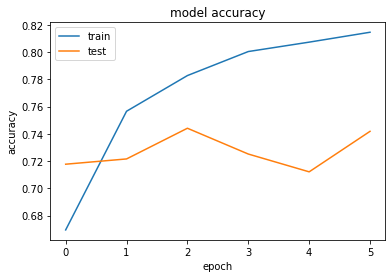

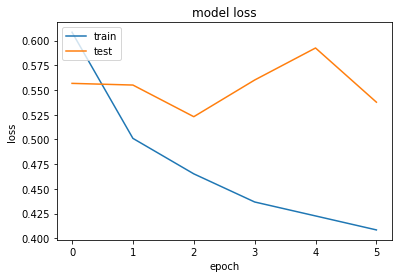

In [ ]:
drawplot(history)

In [ ]:
ins = X[57:60]
prediction(ins)

I laughed all the way through this rotten movie It so unbelievable woman leaves her husband after many years of marriage has breakdown in front of real estate office What happens The office manager comes outside and offers her job Hilarious Next thing you know the two women are going at it Yep they re lesbians Nothing rings true in this Lifetime for Women with nothing better to do movie Clunky dialogue like don want to spend the rest of my life feeling like had chance to be happy and didn take it doesn help There a wealthy distant mother who disapproves of her daughter new relationship sassy black maid unbelievable that in the year film gets made in which there a sassy black maid Hattie McDaniel must be turning in her grave The woman has husband who freaks out and wants custody of the snotty teenage kids Sheesh No cliche is left unturned 
Positive rev
NO SPOILERS After Hitchcock successful first American film Rebecca based upon Daphne DuMarier lush novel of gothic romance and intrigue 

In [ ]:
backend.clear_session()

# **Text Classification with a Convolutional Neural Network**

In [ ]:
model = Sequential()

embedding_layer = Embedding(vocab_size, 100, weights=[embedding_matrix], input_length=maxlen , trainable=False)
model.add(embedding_layer)

model.add(Conv1D(128, 5, activation='relu'))
model.add(GlobalMaxPooling1D())
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

In [ ]:
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 100, 100)          9024800   
_________________________________________________________________
conv1d (Conv1D)              (None, 96, 128)           64128     
_________________________________________________________________
global_max_pooling1d (Global (None, 128)               0         
_________________________________________________________________
dense (Dense)                (None, 1)                 129       
Total params: 9,089,057
Trainable params: 64,257
Non-trainable params: 9,024,800
_________________________________________________________________
None


In [ ]:
history = model.fit(X_train, y_train, batch_size=128, epochs=6, verbose=1, validation_split=0.2)
score = model.evaluate(X_test, y_test, verbose=1)

Epoch 1/6
235/235 [==============================] - 1s 6ms/step - loss: 0.5066 - acc: 0.7484 - val_loss: 0.3974 - val_acc: 0.8220
Epoch 2/6
235/235 [==============================] - 1s 6ms/step - loss: 0.3721 - acc: 0.8347 - val_loss: 0.3719 - val_acc: 0.8329
Epoch 3/6
235/235 [==============================] - 1s 5ms/step - loss: 0.3249 - acc: 0.8618 - val_loss: 0.4248 - val_acc: 0.8064
Epoch 4/6
235/235 [==============================] - 1s 6ms/step - loss: 0.2811 - acc: 0.8858 - val_loss: 0.3509 - val_acc: 0.8427
Epoch 5/6
235/235 [==============================] - 1s 5ms/step - loss: 0.2443 - acc: 0.9082 - val_loss: 0.3688 - val_acc: 0.8367
Epoch 6/6
391/391 [==============================] - 1s 2ms/step - loss: 0.3457 - acc: 0.8454


In [ ]:
print("Test Score:", score[0])
print("Test Accuracy:", score[1])

Test Score: 0.3456566035747528
Test Accuracy: 0.8454399704933167


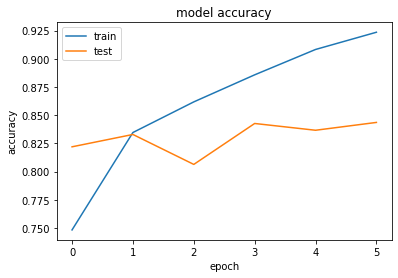

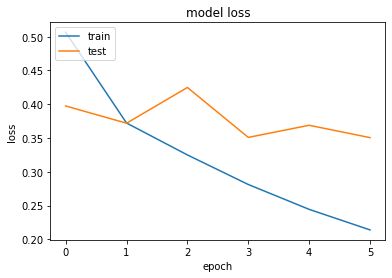

In [ ]:
drawplot(history)

In [ ]:
ins = X[57:60]
prediction(ins)

I laughed all the way through this rotten movie It so unbelievable woman leaves her husband after many years of marriage has breakdown in front of real estate office What happens The office manager comes outside and offers her job Hilarious Next thing you know the two women are going at it Yep they re lesbians Nothing rings true in this Lifetime for Women with nothing better to do movie Clunky dialogue like don want to spend the rest of my life feeling like had chance to be happy and didn take it doesn help There a wealthy distant mother who disapproves of her daughter new relationship sassy black maid unbelievable that in the year film gets made in which there a sassy black maid Hattie McDaniel must be turning in her grave The woman has husband who freaks out and wants custody of the snotty teenage kids Sheesh No cliche is left unturned 
Positive rev
NO SPOILERS After Hitchcock successful first American film Rebecca based upon Daphne DuMarier lush novel of gothic romance and intrigue 

In [ ]:
backend.clear_session()

# **Text Classification with Recurrent Neural Network (LSTM)**

In [ ]:
model = Sequential()
embedding_layer = Embedding(vocab_size, 100, weights=[embedding_matrix], input_length=maxlen , trainable=False)
model.add(embedding_layer)
model.add(LSTM(128))

model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

In [ ]:
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 100, 100)          9024800   
_________________________________________________________________
lstm (LSTM)                  (None, 128)               117248    
_________________________________________________________________
dense (Dense)                (None, 1)                 129       
Total params: 9,142,177
Trainable params: 117,377
Non-trainable params: 9,024,800
_________________________________________________________________
None


In [ ]:
history = model.fit(X_train, y_train, batch_size=128, epochs=6, verbose=1, validation_split=0.2)
score = model.evaluate(X_test, y_test, verbose=1)

Epoch 1/6
235/235 [==============================] - 3s 14ms/step - loss: 0.5459 - acc: 0.7222 - val_loss: 0.5068 - val_acc: 0.7601
Epoch 2/6
235/235 [==============================] - 3s 11ms/step - loss: 0.4530 - acc: 0.7905 - val_loss: 0.4329 - val_acc: 0.7952
Epoch 3/6
235/235 [==============================] - 3s 12ms/step - loss: 0.4052 - acc: 0.8165 - val_loss: 0.3856 - val_acc: 0.8183
Epoch 4/6
235/235 [==============================] - 3s 11ms/step - loss: 0.3708 - acc: 0.8345 - val_loss: 0.3802 - val_acc: 0.8221
Epoch 5/6
235/235 [==============================] - 3s 11ms/step - loss: 0.3514 - acc: 0.8457 - val_loss: 0.3390 - val_acc: 0.8484
Epoch 6/6
391/391 [==============================] - 2s 4ms/step - loss: 0.3489 - acc: 0.8447


In [ ]:
print("Test Score:", score[0])
print("Test Accuracy:", score[1])

Test Score: 0.3489214777946472
Test Accuracy: 0.8447200059890747


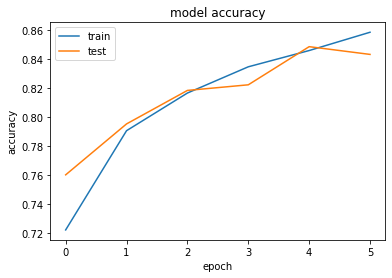

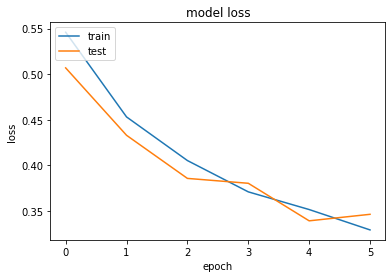

In [ ]:
drawplot(history)

In [ ]:
ins = X[57:60]
prediction(ins)

I laughed all the way through this rotten movie It so unbelievable woman leaves her husband after many years of marriage has breakdown in front of real estate office What happens The office manager comes outside and offers her job Hilarious Next thing you know the two women are going at it Yep they re lesbians Nothing rings true in this Lifetime for Women with nothing better to do movie Clunky dialogue like don want to spend the rest of my life feeling like had chance to be happy and didn take it doesn help There a wealthy distant mother who disapproves of her daughter new relationship sassy black maid unbelievable that in the year film gets made in which there a sassy black maid Hattie McDaniel must be turning in her grave The woman has husband who freaks out and wants custody of the snotty teenage kids Sheesh No cliche is left unturned 
Negative rev
NO SPOILERS After Hitchcock successful first American film Rebecca based upon Daphne DuMarier lush novel of gothic romance and intrigue 

**References :**


1.   Kaggel IMDb dataset
2.   Stackabuse, movies sentiments analysis using DL in keras

